### Week 5: Bayesian linear regression lab

 * #### Aims
     - To implement Bayesian inference over the parameters of the linear model for the Olympic data.
     - To get more experience in the use of Bayesian models for regression, in particular predictions.
     - Practise model selection with marginal likelihood

#### Task 1:  Bayesian treatment of the Olympic regression problem
In this task, we will perform a Bayesian treatment of the Olympic regression problem. 

#####  We start by loading the data and rescaling it to aid with numerics.

In [16]:
import numpy as np
import pylab as plt
%matplotlib inline
np.random.seed(1)


data = np.loadtxt('olympic100m.txt',delimiter=',') # load olympic data
x = data[:,0][:,None] # make x a column vector
t = data[:,1][:,None] # make t a column vector
x = (x - x[0])/4.0 # rescale x 

##### Task 1.1: Set up prior, $p(\mathbf{w})$

We'll define a Gaussian prior over $\mathbf{w}$, with mean $\mathbf{0}$ and covariance $\left[\begin{array}{cc} 100& 0\\0 & 5\end{array}\right]$. We'll also fix $\sigma^2=2$.

In [22]:
prior_mean = np.zeros((2,1)) # vector of mean 
prior_cov = np.array([[100,0],[0,5]]) # covariance matrix
sig_sq = 2 # variance of the additive noise 

##### Task 1.2: Let's see what this prior means by sampling some $\mathbf{w}$ vectors from it and plotting the models (polynomial order = 1)

Use `numpy`'s `multivariate_normal` (docs [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html)) to generate samples from a multivariate Gaussian

(9, 12)

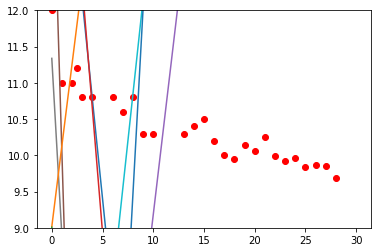

In [23]:
w_samp = np.random.multivariate_normal(prior_mean.flatten(),prior_cov,20) # sampling from multivariate Gaussian distribution 
plt.figure()
plt.plot(x,t,'ro') # plot data (we only need two xs since they're straight lines)
plot_x = np.array([[1,0],[1,30]]) # generate new x (and thus the design matrix) for plotting the sampled model
plt.plot([0,30],np.dot(w_samp,plot_x.T).T)
plt.ylim([9,12])

##### Task 1.3: Draw a contour plot of the prior:
<p>The multivariate Gaussian pdf is given by:
$$ p(\mathbf{x}|\boldsymbol\mu,\boldsymbol\Sigma) = \frac{1}{(2\pi)^{D/2}}\frac{1}{|\boldsymbol\Sigma|^{1/2}}\exp\left\{-\frac{1}{2}(\mathbf{x} - \boldsymbol\mu)^T\boldsymbol\Sigma^{-1}(\mathbf{x}-\boldsymbol\mu)\right\} $$

You can use `numpy`'s `det` function (docs [here](https://numpy.org/doc/2.3/reference/generated/numpy.linalg.det.html)) to compute the matrix determinant $|\boldsymbol\Sigma|$. Note that $D$ is the dimensionality of $\boldsymbol{x}$ and $\boldsymbol{\mu}$.

Text(0,0.5,'$w_1$')

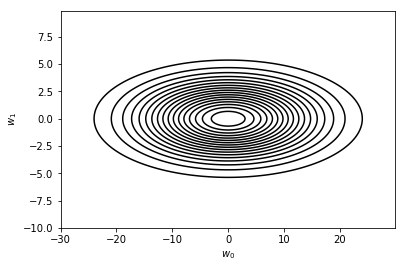

In [24]:
def gaussian2d(mu,sigma,xvals,yvals): # A function to plot 2d Gaussian pdf, 
                                      # here you can set an input for each dimension, i.e. xvals is first component
                                      # of each x and yvals is second component of each x.
                                      # This way can help us to use meshgrid to avoid a double for loop.
    const = (1.0/(2.0*np.pi))*(1.0/np.sqrt(np.linalg.det(sigma)))
    si = np.linalg.inv(sigma)
    xv = xvals-mu[0]
    yv = yvals-mu[1]
    return const * np.exp(-0.5*(xv*xv*si[0][0] + xv*yv*si[1][0] + yv*xv*si[0][1] + yv*yv*si[1][1]))


xp = np.arange(-30,30,0.1) # select a suitable range for first dimension of x
yp = np.arange(-10,10,0.1) # select a suitable range for second dimension of x
Xp,Yp = np.meshgrid(xp,yp) # you can use meshgrid instead of a for loop
Z = gaussian2d(prior_mean,prior_cov,Xp,Yp) 
CS = plt.contour(Xp,Yp,Z,20,colors='k')
plt.xlabel('$w_0$')
plt.ylabel('$w_1$')

##### Task 1.4: Compute the posterior and draw samples from it

First let's write functions to construct the polynomial design matrix, and to compute the posterior mean and covariance
$$\mathbf{\Sigma} = \left(\frac{1}{\sigma^2}\mathbf{X}^{T}\mathbf{X} + \mathbf{S}^{-1}\right)^{-1}$$
$$\boldsymbol\mu = \frac{1}{\sigma^2}\mathbf{\Sigma}\mathbf{X}^{T}\mathbf{t}$$
where $\mathbf{S}$ is the covariance matrix of the prior $p(\mathbf{w})$

In [25]:
def polynomial(x, max_order): # your own function to construct polynomial design matrix (see previous labs)
    X = np.ones_like(x)
    for i in range(1, max_order+1):
        X = np.hstack((X,x**i))
    return(X)

def compute_post_cov(X, prior_cov, sig_sq): # your own function to compute posterior mean
    return(np.linalg.inv((1.0/sig_sq)*np.dot(X.T,X) + np.linalg.inv(prior_cov)) )
 
def compute_post_mean(post_cov, sig_sq, X, t): # your own function to compute posterior covariance
    return(np.dot(post_cov,(1.0/sig_sq)*np.dot(X.T,t) ) )

(9, 12)

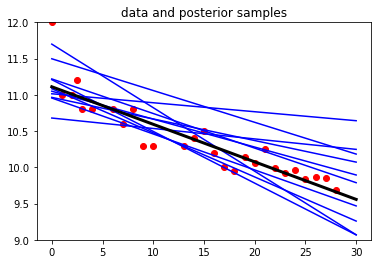

In [26]:
X = polynomial(x, 1) # construct design matrix
post_cov = compute_post_cov(X, prior_cov, sig_sq) # compute posterior mean 
post_mean = compute_post_mean(post_cov,sig_sq,X,t) # compute posterior covariance 

plt.figure()
plt.title('data and posterior samples') 
w_samp = np.random.multivariate_normal(post_mean.flatten(),post_cov,10) # draw some samples
plt.plot(x,t,'ro')
plt.plot([0,30],np.dot(w_samp,plot_x.T).T,'b') # plot the sampled lines, 
                                               # only need 2 points to plot a straight line
plt.plot([0,30],np.dot(plot_x,post_mean),'k',linewidth=3) # plot the posterior mean prediction, 
                                                    # only need 2 points to plot a straight line
plt.ylim([9,12])       



#### Task 2: We'll now look at predictions

##### Task 2.1: Functions for posterior prediction

$$p(t_{new} | \mathbf{X},\mathbf{t},\mathbf{x}_{new},\sigma^2) = {\cal N}(\mathbf{x}_{new}^{T}\boldsymbol\mu,\sigma^2 + \mathbf{x}_{new}^{T}  \mathbf{\Sigma} \mathbf{x}_{new})$$

In [27]:
max_order = 1
test_x = np.linspace(0,100,100)[:,None] # generate some test data
testX = polynomial(test_x, max_order)

pred_mean = np.dot(testX, post_mean) # compute predictive mean
pred_var = sig_sq + np.diag(np.dot(testX,np.dot((post_cov),testX.T))) # compute predictive variance 

#### Task 2.2: Plot error bars 

<ErrorbarContainer object of 3 artists>

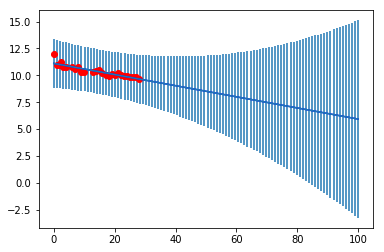

In [28]:
plt.plot(x,t,'ro') # plot data 
plt.plot(test_x,pred_mean,'b') # plot mean prediction 
plt.errorbar(test_x.flatten(),pred_mean.flatten(),yerr=pred_var.flatten()) # plot error bars

#### Task 3: Bayesian regression with scikit-learn

Bayesian linear regression is implemented in scikit-learn by `sklearn.linear_model.BayesianRidge`. Use this method to *approximately* replicate the results of Tasks 1 & 2. The results will differ somewhat from the ones above, for two reason. First, this class also estimates the variance of the likelihood $\sigma^2$ (somewhat like we did in Lecture 4), instead of assuming it is known (as above and as in Lecture 5). Similarly, it estimates the prior on $\boldsymbol{w}$, based on a hyper-prior (i.e. a prior on the prior; if you're interested in the maths, check Bishop's PRML book). To get the error bars, pass `return_std=True` to the  `predict` method.

<ErrorbarContainer object of 3 artists>

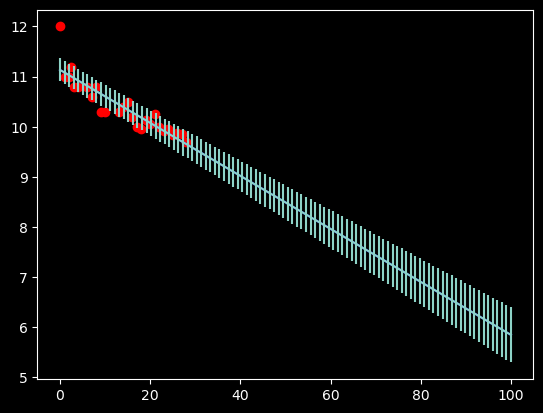

In [17]:
from sklearn.linear_model import BayesianRidge

br = BayesianRidge()
br.fit(x, t.squeeze())

test_x = np.linspace(0, 100, 100)
pred_mean, pred_std = br.predict(test_x[:, None], return_std=True)

plt.plot(x,t,'ro') # plot data
plt.plot(test_x,pred_mean,'b') # plot mean prediction
plt.errorbar(test_x.flatten(),pred_mean.flatten(),yerr=pred_std.flatten()) # plot error bars

#### Task 4: Model selection with the marginal likelihood (optional!)

The marginal likelihood is the denominator in Bayes' rule. It provides an alternative to validation data for performing model comparison. It measures the average performance of _all possible_ models in some class (e.g. linear or polynomial), rather than the likelihood which measures performance of a single model.

_We didn't cover it in the lectures this year, so you will need to do some research if you want to attempt this part!_

##### Task 4.1: Simulate data

Text(0, 0.5, 't')

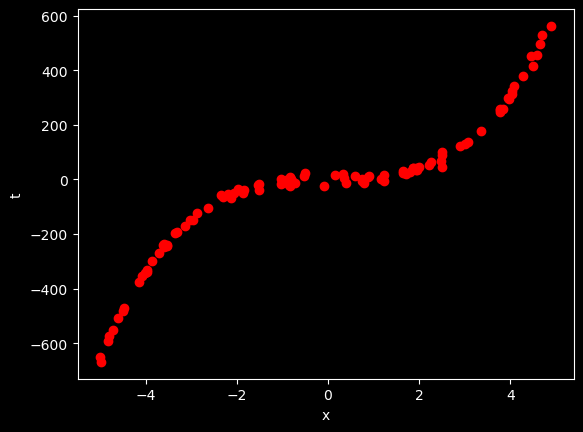

In [18]:
N = 100 # number of data points
x = np.sort((10*np.random.rand(N,1)-5),axis=0) # uniform number between -5 and 5
t = 5*x**3 - x**2 + x # true model # true model, w0=0, w1=1, w2=-1, w3=5 
noise_var = 150 # true sigma^2 = 150
t = t + np.random.randn(N,1)*np.sqrt(noise_var) # add noise
plt.plot(x,t,'ro')
plt.xlabel('x')
plt.ylabel('t')

#### Task 4.2:  Write your function to compute the mean and covariance of the marginal likelihood
$$p(\mathbf{t}|\mathbf{X},\mathbf{t},\sigma^2,\boldsymbol\mu_{0},\mathbf{\Sigma}_{0}) = {\cal N}(\mathbf{X}\boldsymbol\mu_{0},\sigma^2\mathbf{I} + \mathbf{X}\mathbf{\Sigma}_{0}\mathbf{X}^T) $$
where $$\boldsymbol\mu_{0} =\mathbf{0},  \mathbf{\Sigma}_{0} = \mathbf{I}$$

You can use `numpy`'s `eye` function to construct the identity matrix
https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.eye.html

In [16]:
def compute_marg_mean(X, prior_mean): # your function to compute the mean of the marginal likelihood
    return( np.dot(X,prior_mean) )

def compute_marg_cov(X, sig_sq, prior_cov): # your function to compute the covariance of the marginal likelihood
    return (sig_sq*np.eye(X.shape[0]) + np.dot(X,np.dot(prior_cov,X.T)) )

def log_multivariate_gaussian_pdf(x, mean, cov):
    const = -((i+1)/2.0)*np.log(2.0*np.pi) - 0.5*np.log(np.linalg.det(cov))
    log_pdf = const - 0.5*np.dot((x-mean).T,np.dot(np.linalg.inv(cov),x-mean))
    return(log_pdf[0]) 

#### Task 4.3: Computing the marginal likelihood for different polynomial orders, this will be much simpler than cross-validation

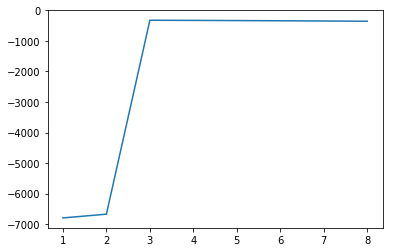

In [17]:
max_order = 8 # max order
log_marg_like = [] 
for i in np.arange(max_order)+1:
    prior_mean = np.zeros((i+1,1)) # setup prior mean, note the dimension should change with polynomial orders
    prior_cov = np.eye(i+1) # setup prior covariance, note the dimension should change with polynomial orders
    X = polynomial(x, i) # construct polynomial design matrix
    marg_cov = compute_marg_cov(X, noise_var, prior_cov) # compute the mean of the marginal likelihood
    marg_mean = compute_marg_mean(X,prior_mean) # compute the covariance of the marginal likelihood
    this_marg = log_multivariate_gaussian_pdf(t, marg_mean, marg_cov) # compute the log of Gaussian pdf
    log_marg_like.append(this_marg) 

##### Task 4.4 Plot  log marginal likelihood vs polynomial order

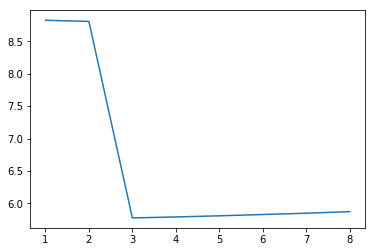

In [18]:
log_marg_like = np.array(log_marg_like) # convert list to array
plt.plot(np.arange(max_order)+1, log_marg_like) # plot log_marg_like vs polynomial order

A bit difficult to see, let's change it to a different scale, say `np.log( -log_marg_like ) `

In [ ]:
plt.plot(np.arange(max_order)+1, np.log( -log_marg_like ) ) # plot the rescaled log marginal likelihood